In [1]:
from typing import Tuple, NamedTuple, Any, List
import textwrap

import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE
import shap
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# We offer pre-filtered Google Drive files to speed up execution of this cell.

#df = pd.read_csv("user_log_format1.csv")  # SHA256: a6bc8eabc40b61a562a5e45c91e9b822418d0d863576b28a9ccd549451e55a92
#df = df[df['item_id'].isin(range(481, 640+1))]
df_user_log = pd.read_csv('https://drive.google.com/uc?id=1DwEvKOYl0hQmd2muwDa13O17smPPgn0D')
df_user_info = pd.read_csv('https://drive.google.com/uc?id=1wM9LY4rAsMLGe6GUZNQd50R8WHiH9xaf')
#df1 = pd.read_csv("user_info_format1.csv")
df2 = pd.read_csv("train_format1.csv")

# Data Visualization

In [64]:
print(np.sum(df2["label"] == 0), np.sum(df2["label"] == 1))
print(f'{np.sum(df2["label"] == 1) / len(df2) * 100:.02f}% are repeat buyers')

244912 15952
6.12% are repeat buyers


In [4]:
df_user_log.describe()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
count,7254.000000,7254.000000,7254.000000,7254.000000,7248.000000,7254.000000,7254.00000
mean,212242.874414,550.680866,856.662807,2248.200441,3430.941777,918.570720,0.32327
std,123871.986646,45.550493,454.733960,1398.951493,2393.470654,196.713235,0.82503
min,192.000000,481.000000,22.000000,2.000000,99.000000,511.000000,0.00000
25%,101420.750000,517.000000,407.000000,1234.000000,1345.000000,729.000000,0.00000
50%,216374.000000,545.000000,748.000000,1923.000000,2462.000000,1006.000000,0.00000
75%,321987.000000,591.000000,1255.000000,3659.000000,5376.000000,1109.000000,0.00000
max,424094.000000,640.000000,1661.000000,4994.000000,8297.000000,1111.000000,3.00000


In [5]:
df_user_log.isnull().any()

user_id        False
item_id        False
cat_id         False
seller_id      False
brand_id        True
time_stamp     False
action_type    False
dtype: bool

<Axes: xlabel='action_type', ylabel='count'>

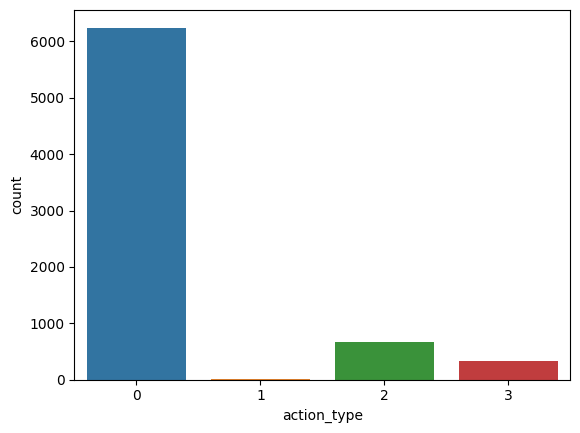

In [6]:
sns.countplot(x='action_type', data=df_user_log)

In [7]:
df_user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


<Axes: xlabel='age_range', ylabel='count'>

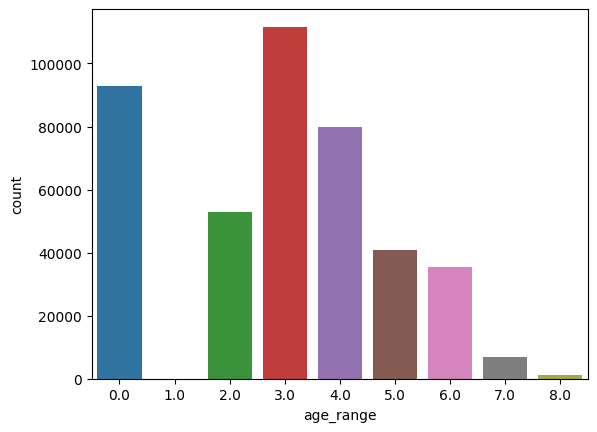

In [8]:
sns.countplot(x='age_range', data=df_user_info)

<Axes: xlabel='gender', ylabel='count'>

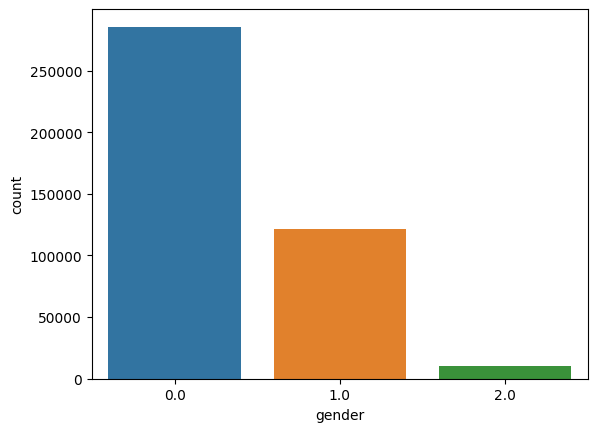

In [9]:
sns.countplot(x='gender', data=df_user_info)

# Feature Engineering
We should analyze the data more to see if we can extract more structured features.

In [10]:
merged_df = pd.merge(pd.merge(df_user_log, df_user_info, on='user_id'), df2, on='user_id')
merged_df = merged_df[merged_df.notnull().all(axis=1)]  # Remove rows with any nulls

merged_df['time_stamp'].astype('str')
merged_df['time_str'] = merged_df['time_stamp'].astype('str')
merged_df['Day'] = merged_df['time_stamp'] % 100
merged_df['Month'] = (merged_df['time_stamp'] - merged_df['Day']) / 100
merged_df['Month'] = merged_df['Month'].astype('int')
merged_df['DayOfYear'] = merged_df['Month'].apply(lambda x: sum([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31][:x])) + merged_df['Day']  # If we have to deal with leap years, I will cry
merged_df['DayOfWeek'] = merged_df['Day'] % 7

merged_df.sort_values('item_id')

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender,merchant_id,label,time_str,Day,Month,DayOfYear,DayOfWeek
2253,421381,481,1331,318,4275.0,1111,0,2.0,0.0,962,0,1111,11,11,345,4
4726,376442,481,1331,318,4275.0,1016,0,2.0,0.0,4173,0,1016,16,10,320,2
2801,179767,481,1331,318,4275.0,1008,0,6.0,1.0,437,0,1008,8,10,312,1
4714,183135,481,1331,318,4275.0,821,0,5.0,0.0,1916,0,821,21,8,264,0
4713,183135,481,1331,318,4275.0,821,0,5.0,0.0,1916,0,821,21,8,264,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,109905,640,612,2246,394.0,1108,0,3.0,0.0,2928,0,1108,8,11,342,1
1260,14473,640,612,2246,394.0,923,0,6.0,0.0,3463,0,923,23,9,296,2
1850,6402,640,612,2246,394.0,1111,0,0.0,1.0,3528,0,1111,11,11,345,4
3403,16102,640,612,2246,394.0,1110,0,2.0,0.0,3288,0,1110,10,11,344,3


In [11]:
merged_df.describe()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender,merchant_id,label,Day,Month,DayOfYear,DayOfWeek
count,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000
mean,212851.840837,550.306477,876.033570,2141.187599,3260.981240,921.772907,0.319313,3.273894,0.343799,2431.043444,0.080174,14.960111,9.068128,290.106438,3.200829
std,122694.289306,45.255385,467.266302,1385.563428,2342.411169,195.902156,0.824361,1.814262,0.620673,1484.175273,0.271589,8.471536,1.999778,57.348899,1.720940
min,192.000000,481.000000,22.000000,2.000000,99.000000,511.000000,0.000000,0.000000,0.000000,10.000000,0.000000,1.000000,5.000000,162.000000,0.000000
25%,112534.000000,517.000000,407.000000,966.000000,1345.000000,730.000000,0.000000,3.000000,0.000000,1200.000000,0.000000,9.000000,7.000000,242.000000,2.000000
50%,217100.000000,545.000000,748.000000,1699.000000,2431.000000,1007.000000,0.000000,3.000000,0.000000,2273.000000,0.000000,11.000000,10.000000,311.000000,4.000000
75%,321643.000000,591.000000,1255.000000,3556.000000,5097.000000,1109.000000,0.000000,4.000000,1.000000,3828.000000,0.000000,24.000000,11.000000,343.000000,4.000000
max,424094.000000,640.000000,1661.000000,4994.000000,8297.000000,1111.000000,3.000000,8.000000,2.000000,4993.000000,1.000000,31.000000,11.000000,345.000000,6.000000


## Data Visualization on New Features



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='Month', ylabel='Density'>

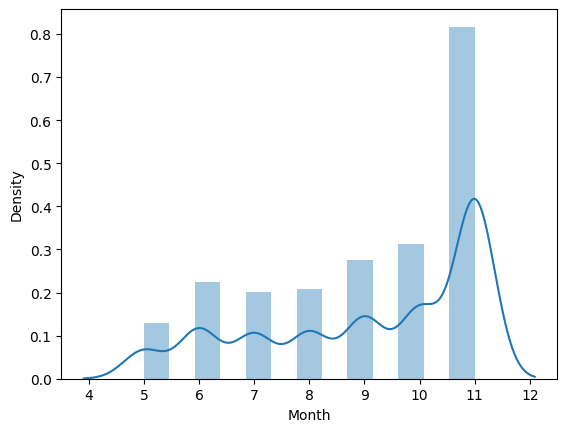

In [12]:
sns.distplot(merged_df['Month'], hist=True)



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='DayOfYear', ylabel='Density'>

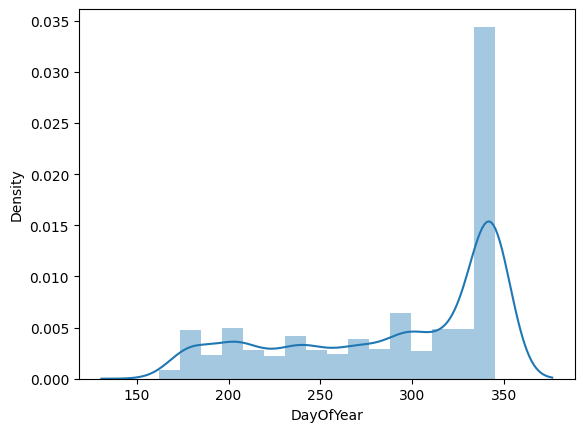

In [13]:
sns.distplot(merged_df['DayOfYear'], hist=True)

<Axes: xlabel='gender', ylabel='count'>

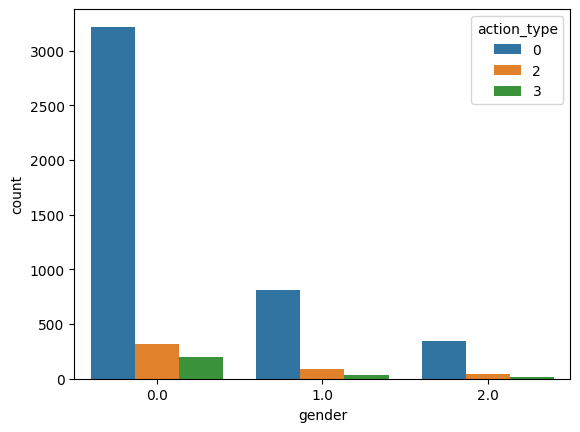

In [14]:
sns.countplot(x='gender', hue='action_type', data=merged_df)

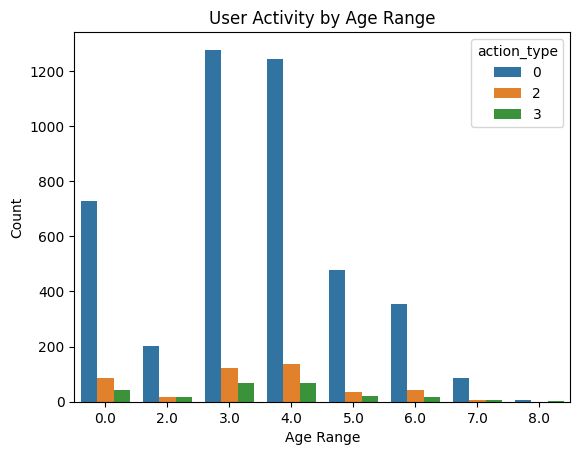

In [15]:
# create a countplot of user activity by age range
sns.countplot(x='age_range', hue='action_type', data=merged_df)
plt.title('User Activity by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Count')

plt.show()

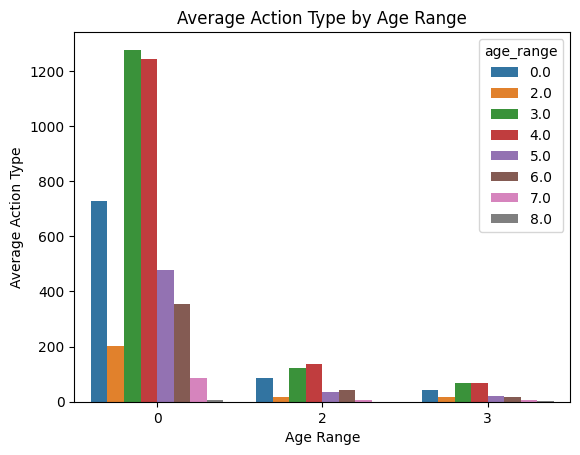

In [16]:
# create a barplot of average action type by age range
sns.countplot(x='action_type', hue='age_range', data=merged_df)
plt.title('Average Action Type by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Average Action Type')
plt.show()

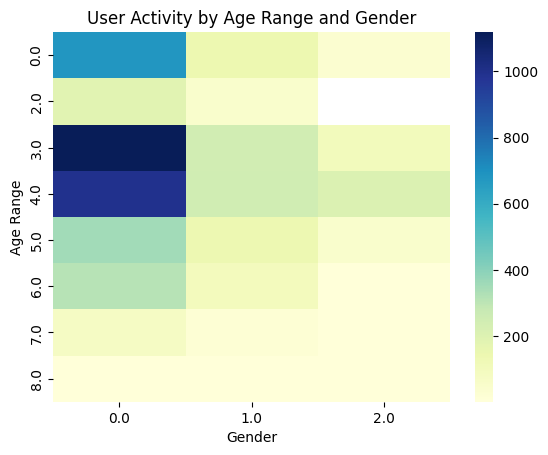

In [17]:
heatmap_df = merged_df.pivot_table(index='age_range', columns='gender', values='action_type', aggfunc='count')
sns.heatmap(heatmap_df, cmap='YlGnBu')
plt.title('User Activity by Age Range and Gender')
plt.xlabel('Gender')
plt.ylabel('Age Range')

plt.show()

# Feature Ranking
Pretty sure statistical summary is taken care by the above task.

In [67]:
# Don't lean into these types too much. Some of them are different, but functionally the same
class EvaluationResults(NamedTuple):
    acc: float
    prec: float
    recall: float
    f1: float
    confusion: np.ndarray
    roc: Tuple[np.ndarray, np.ndarray, np.ndarray]
    roc_auc: float
    model: Any
    columns: List[str]
    data: pd.DataFrame
    
def reduce_data(data, onehot=[], drop=[]):
    #print(data.shape)
    data_reduced = data.drop(columns=drop)
    #print(data_reduced.shape)
    data_reduced = pd.get_dummies(data_reduced, columns=onehot)
    #print(data_reduced.shape)
    
    X = data_reduced.drop(columns=['label'])
    y = data_reduced['label']
    return X, y

def evaluate(model, data, onehot=[], drop=[], name=None, stratify=True):
    X, y = reduce_data(data, onehot, drop)
    
    # Random state is column-invariant
    # We stratify because only 6% of all recorded actions do result in a sale!
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    #print(np.sum(y_train == 1) / len(y_train))
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    roc = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    if name:
        setattr(model, "__name", name)
    else:
        setattr(model, "__name", model.__class__.__name__)
        
    return EvaluationResults(acc, prec, recall, f1, confusion, roc, roc_auc, model, X.columns, X)

def display_evaluation(*evals, show_plots=True, show_table=True):
    table_data = [(x.acc, x.prec, x.recall, x.f1, x.roc_auc) for x in evals]
    conf_data = [x.confusion for x in evals]
    roc_data = [(x.roc, x.roc_auc) for x in evals]
    model_data = [x.model for x in evals]
    
    table = pd.DataFrame(table_data, columns=["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC Score"])
    table = table.rename(mapper={i: x.__name for i, x in enumerate(model_data)})   
    
    if show_table:
        if len(table_data) == 1:
            display(table.T.style.format('{:.2%}'))
        else:
            display(table.style.format('{:.2%}').highlight_max(props='font-weight: bold', axis=0))
            #display(table)
    
    if show_plots:
        fig, ax = plt.subplots()
        for (roc, roc_auc), model in zip(roc_data, model_data):
            fpr, tpr, thresholds = roc
            roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model.__name)
            roc_plot.plot(ax=ax)
            ax.set_title('ROC Curve(s)')
        plt.show()
        
        fig, axs = plt.subplots(nrows=((len(model_data) + 1) // 2), ncols=2, figsize=(8,4*((len(model_data) + 1) // 2)))
        axs = axs.flatten()
        for i, (confusion, model) in enumerate(zip(conf_data, model_data)):
            conf_plot = ConfusionMatrixDisplay(confusion_matrix=confusion)
            conf_plot.plot(ax=axs[i])
            axs[i].set_title(textwrap.fill('Confusion Matrix of ' + model.__name, width=30), fontsize=10)
        fig.tight_layout()
        if len(model_data) % 2 == 1:
            axs[-1].axis('off')
        plt.show()

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest,94.27%,74.47%,43.21%,54.69%,86.58%
Random Forest (unstratified),95.66%,77.08%,52.86%,62.71%,90.34%


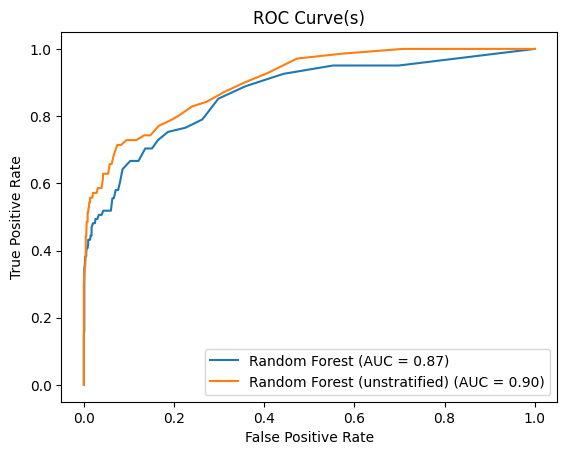

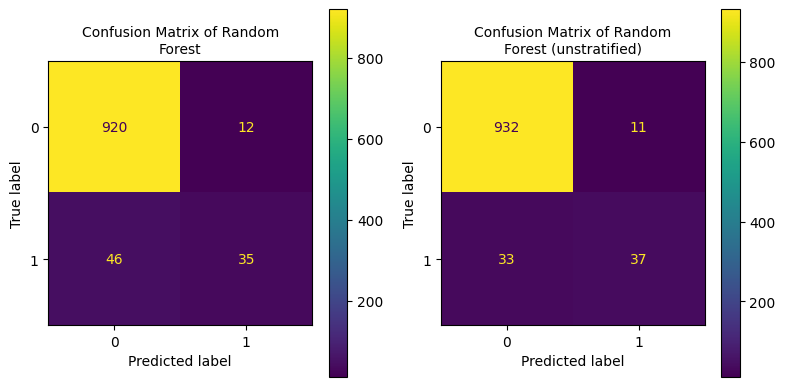

Month          0.013428
action_type    0.015846
DayOfWeek      0.031798
gender         0.032020
brand_id       0.046464
Day            0.046896
DayOfYear      0.047739
time_stamp     0.048990
seller_id      0.050204
item_id        0.051215
time_str       0.051727
cat_id         0.053686
age_range      0.068692
user_id        0.169560
merchant_id    0.271736
dtype: float64

In [68]:
# Before we touch the data, let's gain a benchmark on stratified vs unstratified on the label.
rfor = evaluate(RandomForestClassifier(random_state=0), merged_df, name="Random Forest")
rfor_unstratified = evaluate(RandomForestClassifier(random_state=0), merged_df, name="Random Forest (unstratified)", stratify=False)
display_evaluation(rfor, rfor_unstratified,)
pd.Series(rfor.model.feature_importances_, index=rfor.columns).sort_values().tail(20)

In [20]:
# As we expected, stratified does lower our accuracy, but it also seems to lower our ROC AUC score, which is an interesting note.

onehots = ["merchant_id", "user_id", "age_range", "item_id", "cat_id", "seller_id", "brand_id", "Day", "DayOfWeek", "action_type", "Month"]
rfor_onehot = evaluate(RandomForestClassifier(random_state=0), merged_df, onehot=onehots, name="Random Forest (onehot)")
display_evaluation(rfor, rfor_onehot, show_plots=False)
pd.Series(rfor_onehot.model.feature_importances_, index=rfor_onehot.columns).sort_values().tail(20)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest,94.27%,74.47%,43.21%,54.69%,86.58%
Random Forest (onehot),95.46%,85.71%,51.85%,64.62%,83.22%


merchant_id_4394    0.007361
user_id_37792       0.007483
merchant_id_4771    0.007581
merchant_id_586     0.007656
user_id_267870      0.008696
merchant_id_1346    0.008814
user_id_381946      0.008928
age_range_4.0       0.008965
age_range_3.0       0.009271
merchant_id_191     0.009659
merchant_id_1116    0.009700
user_id_276113      0.010356
user_id_26469       0.010838
user_id_64342       0.011421
gender              0.011633
merchant_id_4049    0.012241
time_str            0.014564
time_stamp          0.015286
DayOfYear           0.015337
merchant_id_4943    0.018450
dtype: float64

In [21]:
s = pd.Series(rfor_onehot.model.feature_importances_, index=rfor_onehot.columns)
for onehot in onehots:
    cols = [_ for _ in s.index if _.startswith(onehot)]
    col_sum = s[cols].sum()
    s = s.drop(cols)
    s[onehot] = col_sum
    #s = s.reindex([onehot], fill_value=col_sum)
s.sort_values().tail(20)

DayOfWeek      0.000000
action_type    0.010920
gender         0.011633
time_str       0.014564
time_stamp     0.015286
Month          0.015445
cat_id         0.025297
brand_id       0.025807
seller_id      0.027406
item_id        0.028282
age_range      0.035808
Day            0.067634
merchant_id    0.326200
user_id        0.395719
dtype: float64

In [22]:
to_drop = ["item_id", "cat_id", "seller_id", "brand_id", "DayOfWeek", "action_type", "Month"]
onehots = ["merchant_id", "user_id", "age_range", "Day"]
rfor_drop = evaluate(RandomForestClassifier(random_state=0), merged_df, drop=to_drop, onehot=onehots, name="Random Forest (onehot, drop)")
display_evaluation(rfor, rfor_onehot, rfor_drop, show_plots=False)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest,94.27%,74.47%,43.21%,54.69%,86.58%
Random Forest (onehot),95.46%,85.71%,51.85%,64.62%,83.22%
"Random Forest (onehot, drop)",95.66%,91.11%,50.62%,65.08%,84.66%


In [23]:
s = pd.Series(rfor_drop.model.feature_importances_, index=rfor_drop.columns)
for onehot in onehots:
    cols = [_ for _ in s.index if _.startswith(onehot)]
    col_sum = s[cols].sum()
    s = s.drop(cols)
    s[onehot] = col_sum
    #s = s.reindex([onehot], fill_value=col_sum)
s.sort_values().tail(20)

gender         0.011471
time_str       0.019267
time_stamp     0.020709
age_range      0.035792
Day            0.060158
merchant_id    0.363110
user_id        0.489493
dtype: float64

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest,94.27%,74.47%,43.21%,54.69%,86.58%
Random Forest (onehot),95.46%,85.71%,51.85%,64.62%,83.22%
"Random Forest (onehot, drop)",95.66%,91.11%,50.62%,65.08%,84.66%
Random Forest (lossy),95.76%,91.30%,51.85%,66.14%,87.40%


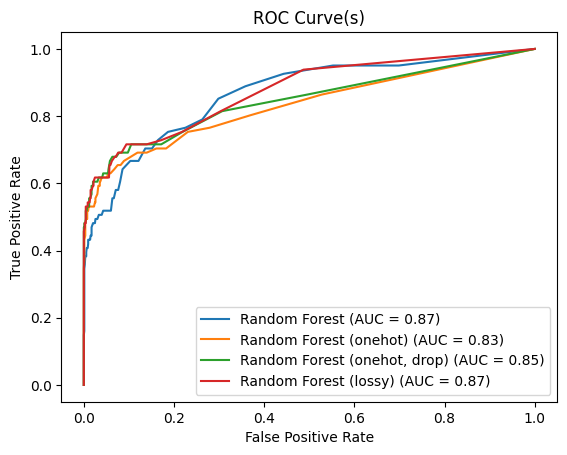

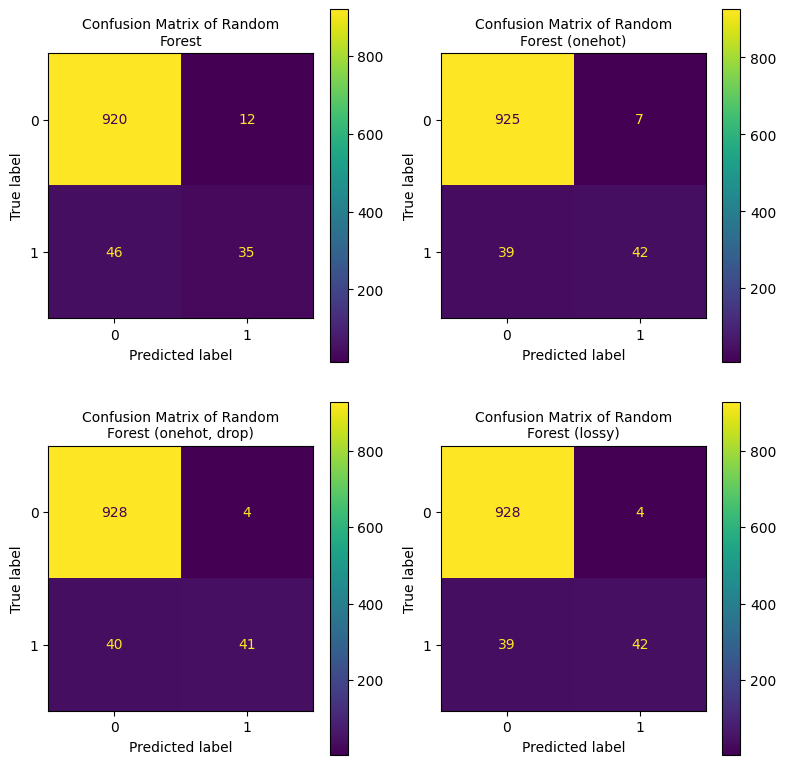

gender         0.012860
time_stamp     0.024620
age_range      0.036648
Day            0.068172
merchant_id    0.364378
user_id        0.493323
dtype: float64

In [24]:
to_drop = ["item_id", "cat_id", "seller_id", "brand_id", "DayOfWeek", "action_type", "Month", "time_str"]
onehots = ["merchant_id", "user_id", "age_range", "Day"]
rfor_lossy = evaluate(RandomForestClassifier(random_state=0), merged_df, drop=to_drop, onehot=onehots, name="Random Forest (lossy)")
display_evaluation(rfor, rfor_onehot, rfor_drop, rfor_lossy)

s = pd.Series(rfor_lossy.model.feature_importances_, index=rfor_lossy.columns)
for onehot in onehots:
    cols = [_ for _ in s.index if _.startswith(onehot)]
    col_sum = s[cols].sum()
    s = s.drop(cols)
    s[onehot] = col_sum
    #s = s.reindex([onehot], fill_value=col_sum)
s.sort_values().tail(20)

<class 'shap.explainers._tree.Tree'>


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


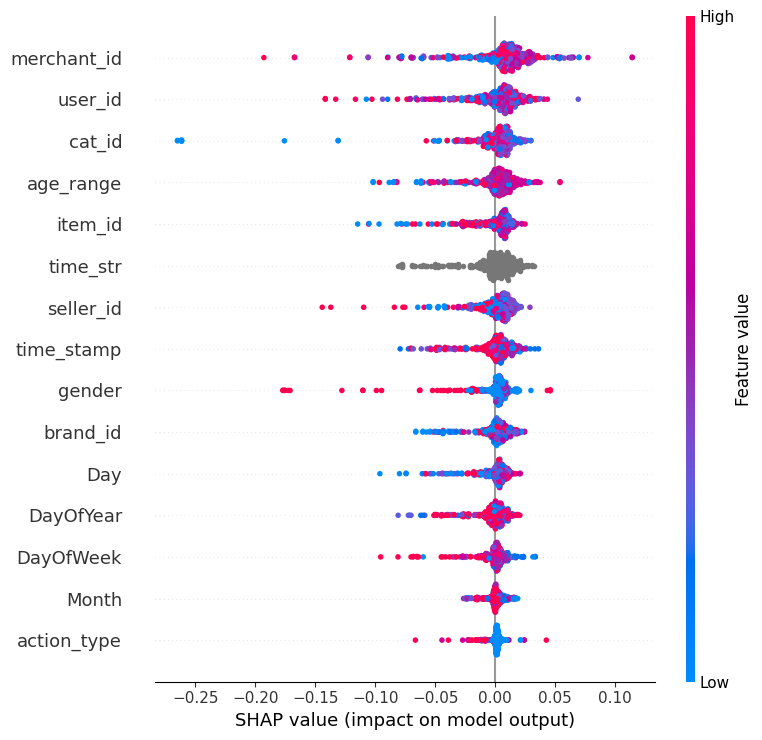

In [25]:
# Let's run Shapley analysis on forest (as that is why we ran it in the first place).
explainer = shap.TreeExplainer(rfor.model)
shap_values = explainer.shap_values(rfor.data.head(500))
print(type(explainer))
shap.summary_plot(shap_values[0], rfor.data.head(500))

In [26]:
# We do not run it on one-hot encoded data, because of the sheer amount of columns it produces.
#
# Note that merchant_id, user_id, cat_id, item_id, seller_id, brand_id are all non-categorical data with values that don't really correspond with one another.
# Meaning that it makes sense that the colors of the dots are mixed. However, we can still see it influence our output.
# We can interpret age range, though. It's also a mixed bag, but we can see the center of the mass shifted rightwards, meaning that any age could influence the output more
# time_str is gray (as it is a string), but also helps us determine the output. time_stamp has a similar shape, which is not surprising, as those two are derived from each other
# gender is interesting. A low value is 0, or female. A high value is 2, or unknown. Most values are female, but they continue to influence.
# Rather, the unknown gender has a much greater impact on the model output. This might be because there are only so many unknown genders.
# Perhaps not all data has been filled in for the unknown gender, meaning our prediction goes out the window
# Day, day of year, day of week, month are all weak, but do influence the output.
# Action type isn't so useful, but any action besides clicks do influence the model output more.

0.9993429562971392
0.9999950328653259


,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),95.76%,91.30%,51.85%,66.14%,87.40%
PCA n=1 RFor Pipeline,93.88%,61.73%,61.73%,61.73%,79.94%
PCA n=5 RFor Pipeline,96.05%,95.56%,53.09%,68.25%,86.77%


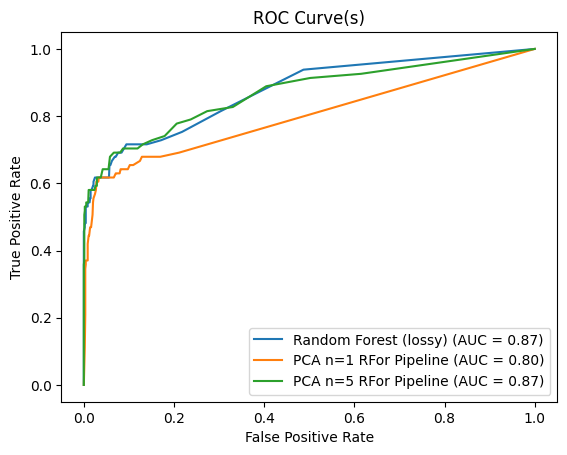

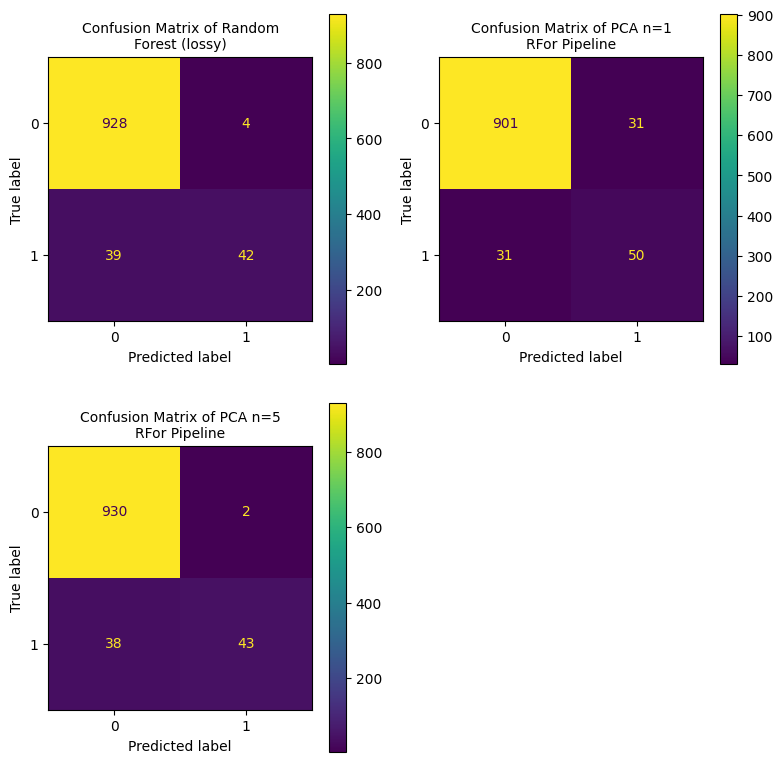

In [27]:
# Now let's do some PCA!

pca1 = PCA(n_components=1).fit(reduce_data(merged_df)[0])
print(sum(pca1.explained_variance_ratio_))
pca5 = PCA(n_components=5).fit(reduce_data(merged_df)[0])
print(sum(pca5.explained_variance_ratio_))
pipeline1 = Pipeline([
    ('pca', PCA(n_components=1)),
    ('clf', RandomForestClassifier(random_state=0))
])
pca1_rfor = evaluate(pipeline1, merged_df, name="PCA n=1 RFor Pipeline")
pipeline2 = Pipeline([
    ('pca', PCA(n_components=5)),
    ('clf', RandomForestClassifier(random_state=0))
])
pca5_rfor = evaluate(pipeline2, merged_df, name="PCA n=5 RFor Pipeline")
display_evaluation(rfor_lossy, pca1_rfor, pca5_rfor)

In [28]:
# What if we dropped and one-hot the same columns as we did for Random Forest, lossy?
pipeline1_lossy = Pipeline([
    ('pca', PCA(n_components=1)),
    ('clf', RandomForestClassifier(random_state=0))
])
pca1_rfor_lossy = evaluate(pipeline1_lossy, merged_df, drop=to_drop, onehot=onehots, name="PCA n=1 RFor Pipeline (lossy)")
pipeline2_lossy = Pipeline([
    ('pca', PCA(n_components=5)),
    ('clf', RandomForestClassifier(random_state=0))
])
pca5_rfor_lossy = evaluate(pipeline2_lossy, merged_df, drop=to_drop, onehot=onehots, name="PCA n=5 RFor Pipeline (lossy)")
display_evaluation(rfor_lossy, pca1_rfor, pca5_rfor, pca1_rfor_lossy, pca5_rfor_lossy, show_plots=False)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),95.76%,91.30%,51.85%,66.14%,87.40%
PCA n=1 RFor Pipeline,93.88%,61.73%,61.73%,61.73%,79.94%
PCA n=5 RFor Pipeline,96.05%,95.56%,53.09%,68.25%,86.77%
PCA n=1 RFor Pipeline (lossy),91.31%,39.39%,16.05%,22.81%,70.60%
PCA n=5 RFor Pipeline (lossy),94.97%,82.61%,46.91%,59.84%,82.48%


<Axes: >

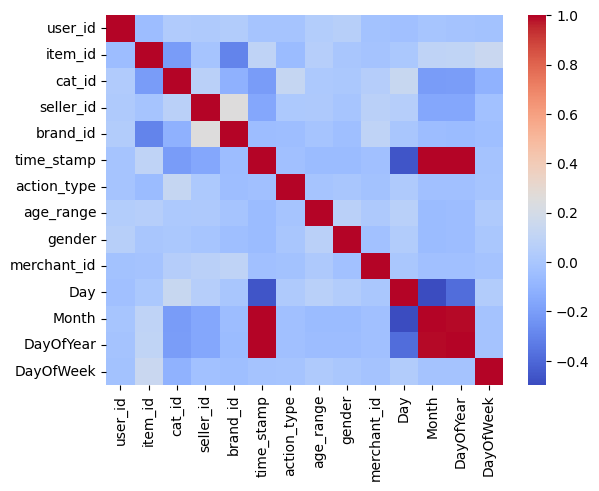

In [29]:
# Here's some correlations
# We only do correlations on reduced, as doing so on one-hot is computationally expensive to visualize (due to the many columns)
sns.heatmap(reduce_data(merged_df, drop=["time_str"])[0].corr(), cmap='coolwarm')

<Axes: >

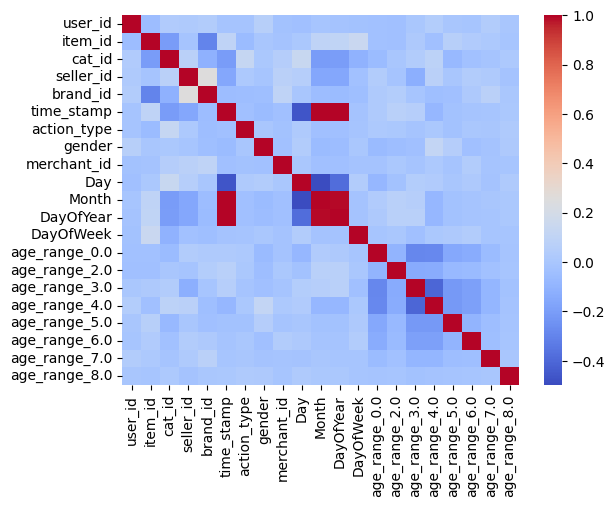

In [30]:
# If we drop some columns, we can visualize it, although it is harder to interpret due to the poor x-axis ticks
temp = reduce_data(merged_df, drop=["time_str"], onehot=["age_range"])[0]
sns.heatmap(temp.corr(), cmap='coolwarm')

In [31]:
# Let's perform LDA
# The interesting thing about this LDA is that it always returns zero, messing up precision, recall, and F1 scores.
lda = evaluate(LinearDiscriminantAnalysis(store_covariance=True), merged_df, name="LDA")
display_evaluation(rfor_lossy, pca5_rfor, lda, show_plots=False)
pd.Series(np.abs(lda.model.coef_[0]), index=lda.columns).sort_values().tail(20)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),95.76%,91.30%,51.85%,66.14%,87.40%
PCA n=5 RFor Pipeline,96.05%,95.56%,53.09%,68.25%,86.77%
LDA,92.00%,0.00%,0.00%,0.00%,58.19%


user_id        1.336001e-07
seller_id      9.700846e-06
brand_id       1.496294e-05
merchant_id    4.174141e-05
cat_id         6.544245e-05
item_id        1.196324e-04
time_stamp     8.051135e-03
time_str       8.051135e-03
age_range      4.252173e-02
Day            5.889541e-02
DayOfWeek      6.209768e-02
DayOfYear      7.433762e-02
action_type    1.179501e-01
gender         1.420786e-01
Month          7.612324e-01
dtype: float64

In [32]:
# But if we add in onehots, we get a different answer
onehots = ["merchant_id", "user_id", "age_range", "item_id", "cat_id", "seller_id", "brand_id", "Day", "DayOfWeek", "action_type", "Month"]
lda_onehot = evaluate(LinearDiscriminantAnalysis(), merged_df, onehot=onehots, name="LDA (onehot)")
display_evaluation(rfor_lossy, pca5_rfor, lda, lda_onehot, show_plots=False)
pd.Series(np.abs(lda_onehot.model.coef_[0]), index=lda_onehot.columns).sort_values().tail(20)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),95.76%,91.30%,51.85%,66.14%,87.40%
PCA n=5 RFor Pipeline,96.05%,95.56%,53.09%,68.25%,86.77%
LDA,92.00%,0.00%,0.00%,0.00%,58.19%
LDA (onehot),93.88%,60.92%,65.43%,63.10%,85.07%


user_id_231912      319.450981
user_id_361876      320.270192
user_id_261682      321.609118
user_id_382188      324.742282
user_id_113537      326.826422
user_id_409108      330.507625
user_id_265295      330.665701
user_id_389589      341.056752
user_id_279419      356.476893
merchant_id_4942    358.897944
merchant_id_747     358.897944
merchant_id_2696    358.897944
user_id_83846       362.358714
merchant_id_4420    366.062634
user_id_132468      374.643676
user_id_388863      375.340018
user_id_23399       388.346888
user_id_381820      497.450398
user_id_109932      537.886684
user_id_21690       544.602563
dtype: float64

In [33]:
s = pd.Series(np.abs(lda_onehot.model.coef_[0]), index=lda_onehot.columns)
for onehot in onehots:
    cols = [_ for _ in s.index if _.startswith(onehot)]
    col_sum = s[cols].sum()
    s = s.drop(cols)
    s[onehot] = col_sum
    #s = s.reindex([onehot], fill_value=col_sum)
s.sort_values().tail(20)

DayOfWeek          0.000000
time_stamp         0.000560
time_str           0.000560
action_type        0.599924
gender             2.719022
Month              6.097425
age_range         25.625337
Day               30.322355
cat_id           499.464789
seller_id        986.730257
brand_id         988.323949
item_id         1043.370707
merchant_id    35167.922747
user_id        98711.589921
dtype: float64

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),95.76%,91.30%,51.85%,66.14%,87.40%
PCA n=5 RFor Pipeline,96.05%,95.56%,53.09%,68.25%,86.77%
LDA,92.00%,0.00%,0.00%,0.00%,58.19%
LDA (onehot),93.88%,60.92%,65.43%,63.10%,85.07%
LDA (lossy),93.88%,60.92%,65.43%,63.10%,85.07%


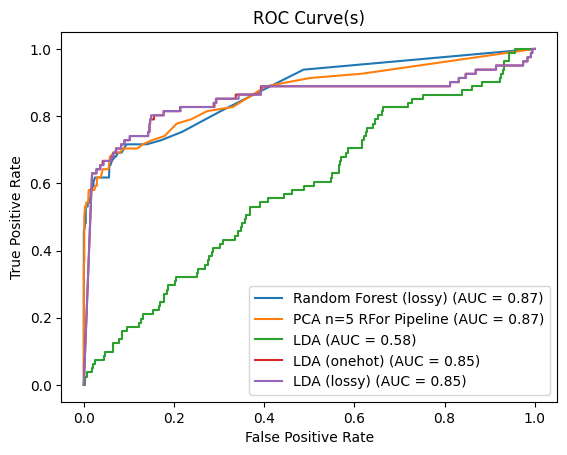

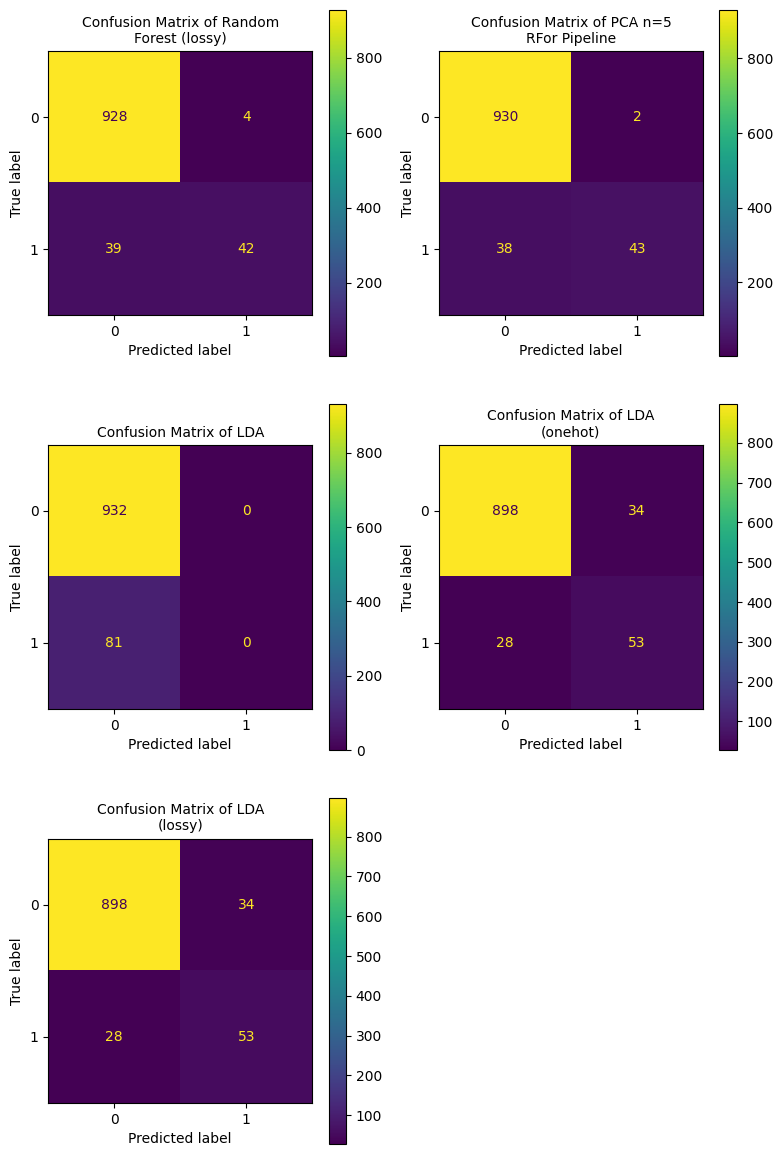

gender             2.718959
Month              6.061797
age_range         25.726076
Day               29.849858
cat_id           499.062047
seller_id        986.217726
brand_id         987.868564
item_id         1042.538446
merchant_id    35168.615943
user_id        98712.210610
dtype: float64

In [34]:
to_drop = ["DayOfWeek", "time_stamp", "time_str", "action_type"]
onehots = ["merchant_id", "user_id", "age_range", "item_id", "cat_id", "seller_id", "brand_id", "Day", "Month"]
lda_lossy = evaluate(LinearDiscriminantAnalysis(), merged_df, drop=to_drop, onehot=onehots, name="LDA (lossy)")
display_evaluation(rfor_lossy, pca5_rfor, lda, lda_onehot, lda_lossy)
s = pd.Series(np.abs(lda_lossy.model.coef_[0]), index=lda_lossy.columns)
for onehot in onehots:
    cols = [_ for _ in s.index if _.startswith(onehot)]
    col_sum = s[cols].sum()
    s = s.drop(cols)
    s[onehot] = col_sum
    #s = s.reindex([onehot], fill_value=col_sum)
s.sort_values().tail(20)

<Axes: >

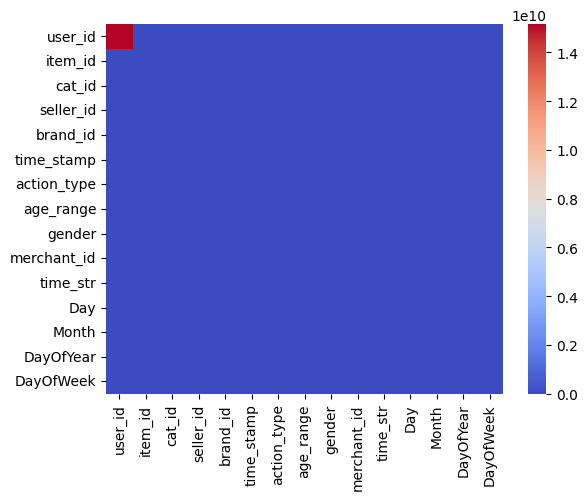

In [36]:
sns.heatmap(lda.model.covariance_, cmap='coolwarm', xticklabels=lda.columns, yticklabels=lda.columns)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


<Axes: >

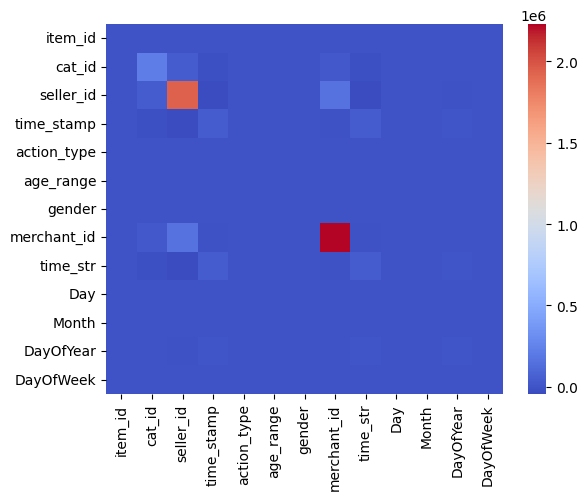

In [37]:
lda_reduced = evaluate(LinearDiscriminantAnalysis(store_covariance=True), merged_df, drop=["user_id", "brand_id"], name="LDA (reduced)")
sns.heatmap(lda_reduced.model.covariance_, cmap='coolwarm', xticklabels=lda_reduced.columns, yticklabels=lda_reduced.columns)

In [38]:
# Let's use RFE for feature analysis. Let's go back to Random Forest

# Let's focus on 5 features for now, as that was beneficial for us in PCA.
rfe_rfors = []
for i in range(1, 10+1):
    rfe_rfors.append(evaluate(RFE(RandomForestClassifier(random_state=0), n_features_to_select=i), merged_df, name=f"Random Forest (RFE {i})"))
display_evaluation(rfor, rfor_lossy, pca5_rfor, *rfe_rfors, show_plots=False)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest,94.27%,74.47%,43.21%,54.69%,86.58%
Random Forest (lossy),95.76%,91.30%,51.85%,66.14%,87.40%
PCA n=5 RFor Pipeline,96.05%,95.56%,53.09%,68.25%,86.77%
Random Forest (RFE 1),91.02%,43.06%,38.27%,40.52%,76.50%
Random Forest (RFE 2),96.05%,87.27%,59.26%,70.59%,81.56%
Random Forest (RFE 3),95.36%,86.96%,49.38%,62.99%,86.49%
Random Forest (RFE 4),95.26%,85.11%,49.38%,62.50%,88.18%
Random Forest (RFE 5),95.26%,86.67%,48.15%,61.90%,88.06%
Random Forest (RFE 6),94.97%,82.61%,46.91%,59.84%,87.55%
Random Forest (RFE 7),95.26%,86.67%,48.15%,61.90%,86.61%


In [39]:
# We can't use it on lossy because the number of features blows out of proportion, taking forever.
# We could also use it on LDA, but we do not because regular LDA returns all zeros for its prediction, meaning we have little to optimize for
# Let's see if we can tune the pipeline
pipeline2_rfe = Pipeline([
    ('pca', PCA(n_components=4)),
    ('clf', RandomForestClassifier(random_state=0))
])
pca5_rfor_rfe = evaluate(RFE(pipeline2_rfe, n_features_to_select=4, importance_getter="named_steps.clf.feature_importances_"), merged_df, name="PCA n=5 RFor Pipeline (RFE)")
display_evaluation(rfor, rfor_lossy, pca5_rfor, pca5_rfor_rfe, show_plots=False)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest,94.27%,74.47%,43.21%,54.69%,86.58%
Random Forest (lossy),95.76%,91.30%,51.85%,66.14%,87.40%
PCA n=5 RFor Pipeline,96.05%,95.56%,53.09%,68.25%,86.77%
PCA n=5 RFor Pipeline (RFE),91.12%,42.11%,29.63%,34.78%,73.01%


In [40]:
# It's clear that running RFE isn't exactly the best if we already do feature extraction.

# Prediction Model
In addition to the Random Forest, PCA, and LDA above, we include a naive Bayes classifier and non-parametric techniques.

In [41]:
# We assume the data is normally distributed
bayes = evaluate(GaussianNB(), merged_df, name="Bayes")
display_evaluation(rfor_lossy, pca5_rfor, lda_lossy, bayes, show_plots=False)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),95.76%,91.30%,51.85%,66.14%,87.40%
PCA n=5 RFor Pipeline,96.05%,95.56%,53.09%,68.25%,86.77%
LDA (lossy),93.88%,60.92%,65.43%,63.10%,85.07%
Bayes,92.00%,0.00%,0.00%,0.00%,60.77%


In [42]:
onehots = ["merchant_id", "user_id", "age_range", "item_id", "cat_id", "seller_id", "brand_id", "Day", "DayOfWeek", "action_type", "Month"]
bayes_onehot = evaluate(GaussianNB(), merged_df, onehot=onehots, name="Bayes (onehot)")
display_evaluation(rfor_lossy, pca5_rfor, lda_lossy, bayes, bayes_onehot, show_plots=False)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),95.76%,91.30%,51.85%,66.14%,87.40%
PCA n=5 RFor Pipeline,96.05%,95.56%,53.09%,68.25%,86.77%
LDA (lossy),93.88%,60.92%,65.43%,63.10%,85.07%
Bayes,92.00%,0.00%,0.00%,0.00%,60.77%
Bayes (onehot),82.82%,26.87%,66.67%,38.30%,75.45%


In [43]:
onehots = ["merchant_id", "user_id", "age_range", "item_id", "cat_id", "seller_id", "brand_id", "Day", "DayOfWeek", "action_type", "Month"]
bayes_bern = evaluate(BernoulliNB(), merged_df, onehot=onehots, name="Bayes (Bernoulli)")
display_evaluation(rfor_lossy, pca5_rfor, lda_lossy, bayes_onehot, bayes_bern, show_plots=False)

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),95.76%,91.30%,51.85%,66.14%,87.40%
PCA n=5 RFor Pipeline,96.05%,95.56%,53.09%,68.25%,86.77%
LDA (lossy),93.88%,60.92%,65.43%,63.10%,85.07%
Bayes (onehot),82.82%,26.87%,66.67%,38.30%,75.45%
Bayes (Bernoulli),91.71%,33.33%,3.70%,6.67%,76.52%


,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),95.76%,91.30%,51.85%,66.14%,87.40%
PCA n=5 RFor Pipeline,96.05%,95.56%,53.09%,68.25%,86.77%
LDA (lossy),93.88%,60.92%,65.43%,63.10%,85.07%
Bayes (onehot),82.82%,26.87%,66.67%,38.30%,75.45%
kNN (k=1),93.19%,56.98%,60.49%,58.68%,78.26%
kNN (k=2),94.08%,76.92%,37.04%,50.00%,78.68%
kNN (k=3),92.99%,58.93%,40.74%,48.18%,77.56%
kNN (k=4),93.39%,66.67%,34.57%,45.53%,77.71%
kNN (k=5),92.50%,54.72%,35.80%,43.28%,78.82%
kNN (k=6),93.19%,65.00%,32.10%,42.98%,78.11%


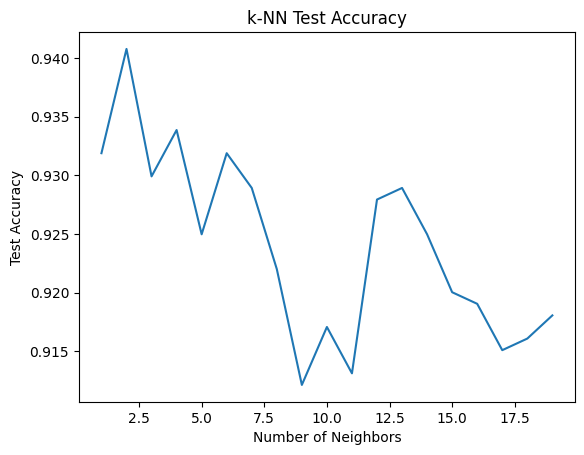

2 0.9407699901283317


In [44]:
# Let's move to kNN. Let's determine which k value is the best.
k_range = range(1, 20)
knns = []
for k in k_range:
    knns.append(evaluate(KNeighborsClassifier(n_neighbors=k), merged_df, name=f"kNN (k={k})"))
display_evaluation(rfor_lossy, pca5_rfor, lda_lossy, bayes_onehot, *knns, show_plots=False)

plt.plot(k_range, [_.acc for _ in knns])
plt.xlabel('Number of Neighbors')
plt.ylabel('Test Accuracy')
plt.title('k-NN Test Accuracy')
plt.show()
print(k_range[np.argmax([_.acc for _ in knns])], np.max([_.acc for _ in knns]))

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),95.76%,91.30%,51.85%,66.14%,87.40%
PCA n=5 RFor Pipeline,96.05%,95.56%,53.09%,68.25%,86.77%
LDA (lossy),93.88%,60.92%,65.43%,63.10%,85.07%
Bayes (onehot),82.82%,26.87%,66.67%,38.30%,75.45%
kNN (k=1 onehot),91.91%,49.33%,45.68%,47.44%,70.80%
kNN (k=2 onehot),93.68%,81.48%,27.16%,40.74%,71.47%
kNN (k=3 onehot),92.30%,53.49%,28.40%,37.10%,71.39%
kNN (k=4 onehot),92.30%,56.52%,16.05%,25.00%,71.65%
kNN (k=5 onehot),91.71%,45.16%,17.28%,25.00%,71.28%
kNN (k=6 onehot),92.69%,70.59%,14.81%,24.49%,71.71%


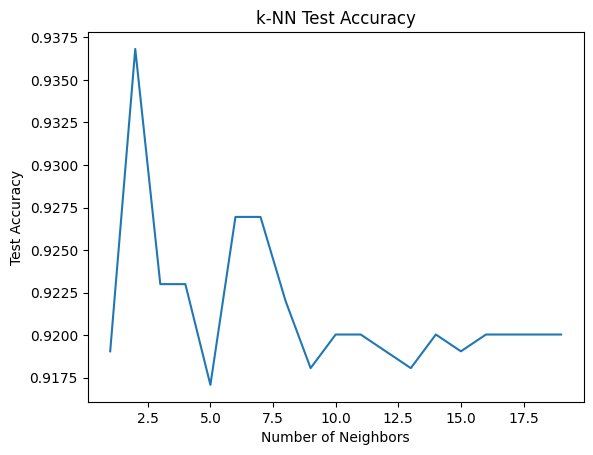

2 0.9368213228035538


In [45]:
# It appears that k=6 is the best. Does this apply to one-hot?
onehots = ["merchant_id", "user_id", "age_range", "item_id", "cat_id", "seller_id", "brand_id", "Day", "DayOfWeek", "action_type", "Month"]
k_range = range(1, 20)
knns = []
for k in k_range:
    knns.append(evaluate(KNeighborsClassifier(n_neighbors=k), merged_df, onehot=onehots, name=f"kNN (k={k} onehot)"))
display_evaluation(rfor_lossy, pca5_rfor, lda_lossy, bayes_onehot, *knns, show_plots=False)

plt.plot(k_range, [_.acc for _ in knns])
plt.xlabel('Number of Neighbors')
plt.ylabel('Test Accuracy')
plt.title('k-NN Test Accuracy')
plt.show()
print(k_range[np.argmax([_.acc for _ in knns])], np.max([_.acc for _ in knns]))

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Random Forest (lossy),95.76%,91.30%,51.85%,66.14%,87.40%
PCA n=5 RFor Pipeline,96.05%,95.56%,53.09%,68.25%,86.77%
LDA (lossy),93.88%,60.92%,65.43%,63.10%,85.07%
Bayes (onehot),82.82%,26.87%,66.67%,38.30%,75.45%
"kNN (k=2, p=1)",93.98%,75.00%,37.04%,49.59%,79.25%
"kNN (k=2, p=2)",94.08%,76.92%,37.04%,50.00%,78.68%
"kNN (k=2, p=3)",94.27%,78.05%,39.51%,52.46%,78.91%
"kNN (k=2, p=9999)",93.48%,100.00%,18.52%,31.25%,68.52%


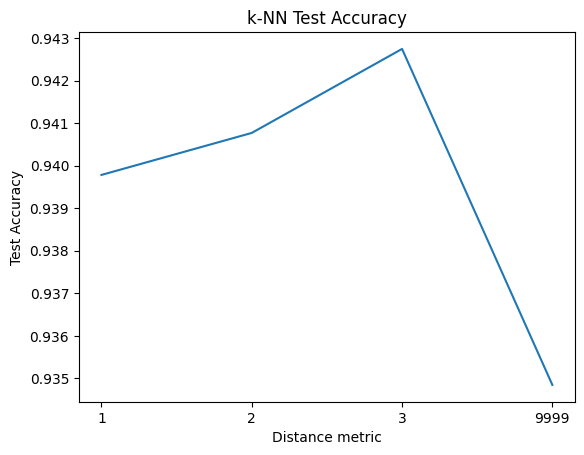

3 0.9427443237907206


In [46]:
# Yes. Using k=2, does different distance measures mark it better?
onehots = ["merchant_id", "user_id", "age_range", "item_id", "cat_id", "seller_id", "brand_id", "Day", "DayOfWeek", "action_type", "Month"]
knns = []
p_range = [1, 2, 3, 9999] # 9999 represents Linf

for p in p_range:
    knns.append(evaluate(KNeighborsClassifier(n_neighbors=2, p=p), merged_df, name=f"kNN (k=2, p={p})"))
display_evaluation(rfor_lossy, pca5_rfor, lda_lossy, bayes_onehot, *knns, show_plots=False)
plt.plot([1, 2, 3, 4], [_.acc for _ in knns])
plt.xticks([1, 2, 3, 4], p_range)
plt.xlabel('Distance metric')
plt.ylabel('Test Accuracy')
plt.title('k-NN Test Accuracy')
plt.show()
print(p_range[np.argmax([_.acc for _ in knns])], np.max([_.acc for _ in knns]))

# Model Evaluation
Let's do this once we're happy with all our models